# Packages

In [90]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt
%matplotlib inline

## Reading the data in

In [2]:
insurance_data = pd.read_csv("insurance.csv")
copy_of_insurance_data = pd.read_csv("insurance.csv")

## Quick data analysis and transformation

In [3]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
regions_df = pd.get_dummies(insurance_data['region'])

In [5]:
insurance_data = pd.concat([insurance_data, regions_df], axis = 1)

In [6]:
insurance_data = insurance_data.drop(['region'], axis = 1)

In [7]:
insurance_data['sex'] = insurance_data['sex'].eq('male').mul(1)

In [8]:
insurance_data['smoker'] = insurance_data['smoker'].eq('yes').mul(1)

In [9]:
## Checking to ensure that the initial transformations have been done
insurance_data

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,1,0,0
1334,18,0,31.920,0,0,2205.98080,1,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,0,1


#### Visualising the data

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1, 'Distribution of charges')

<Figure size 864x576 with 0 Axes>

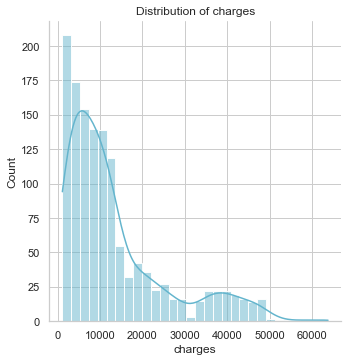

In [10]:
sns.set(style = 'whitegrid')
f, ax = plt.subplots(1,0, figsize = (12,8))
ax = sns.displot(insurance_data['charges'], kde = True, color = 'c')
plt.title('Distribution of charges')

The charge data shows a significant skewed to the right. This could be transformed with a log transformation. This will be done as a variation of the modelling. 

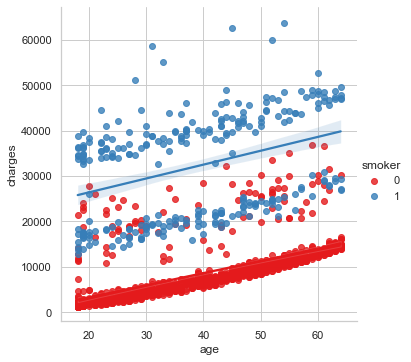

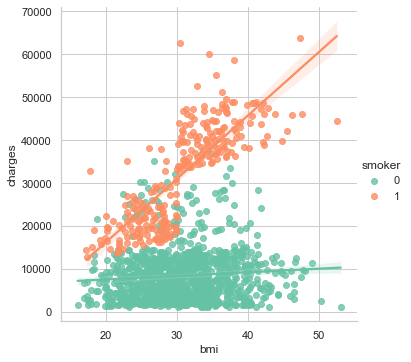

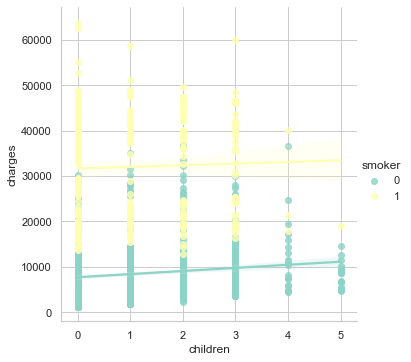

In [11]:
ax = sns.lmplot(x = 'age', y = 'charges', data=insurance_data, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=insurance_data, hue='smoker', palette='Set2')
ax = sns.lmplot(x = 'children', y = 'charges', data=insurance_data, hue='smoker', palette='Set3')

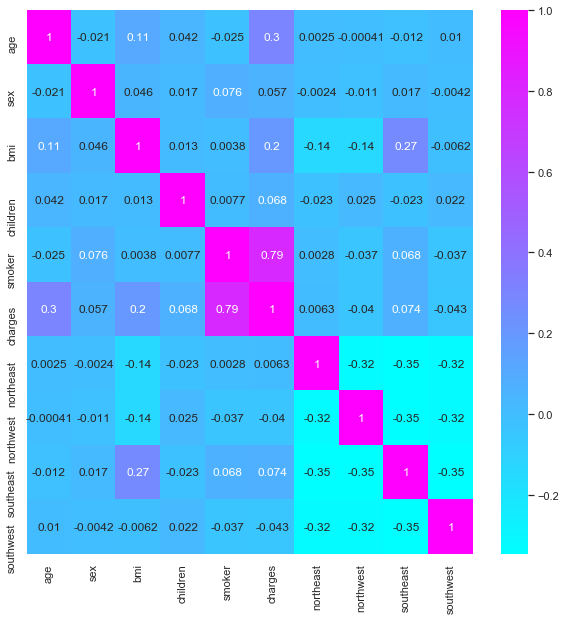

In [12]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(insurance_data.corr(), annot=True, cmap='cool')

**Splitting the dataset and initial model fit**

In [13]:
person_details = insurance_data.iloc[: ,[0,1,2,3,4,6,7,8,9]]
person_charges = insurance_data.iloc[:,[5]]

In [14]:
model = sm.OLS(person_charges, person_details)

In [15]:
fitted_model = model.fit()

In [16]:
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Sat, 16 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:17:16   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          256.8564     11.899     21.587      0.0

The model summary illustrates that all of the variables are statistically significant from their p-values being less than 0.05. The adjusted r-squared value shows that almost 77% of the charges values are explained by this data.

However, it should be noted that the data types are in different metrics and so a data transformation method should be considered in a model iteration. 

### Creating a new variable to help with the stratified split

In [17]:
median_charge = insurance_data['charges'].median()

In [18]:
insurance_data['charge_greater_than_median'] = insurance_data['charges'] > median_charge

In [19]:
insurance_data['charge_greater_than_median'] = insurance_data['charge_greater_than_median'].eq('True').mul(1)

In [20]:
X_set = insurance_data.iloc[: ,[0,1,2,3,4,6,7,8,9]]
Y_set = insurance_data.iloc[: ,[5]]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_set, Y_set, test_size = 0.30,
                                                    random_state = 42,
                                                    stratify = insurance_data['charge_greater_than_median'])

In [22]:
### training and testing
simple_model = sm.OLS(y_train, X_train['age'])
fitted_simple_model = simple_model.fit()

In [23]:
print(fitted_simple_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.587
Model:                            OLS   Adj. R-squared (uncentered):              0.587
Method:                 Least Squares   F-statistic:                              1330.
Date:                Sat, 16 Oct 2021   Prob (F-statistic):                   7.86e-182
Time:                        13:17:16   Log-Likelihood:                         -10094.
No. Observations:                 936   AIC:                                  2.019e+04
Df Residuals:                     935   BIC:                                  2.019e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [24]:
predictions = fitted_simple_model.predict(X_test['age'])

In [25]:
preds_and_results = zip(predictions,y_test['charges'])
preds_and_results = list(preds_and_results)

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


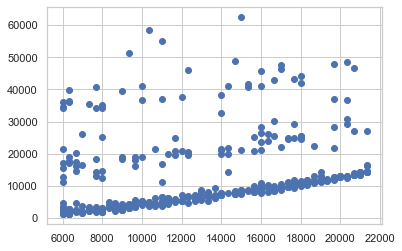

In [26]:
fig, ax = plt.subplots()
ax.plot(predictions, y_test['charges'], "o", label = "Data")

In [27]:
print(sm.tools.eval_measures.rmse(y_test['charges'], predictions))

11441.316191511609


The basic model, which uses only the age feature, is pretty poor. Though, with only one feature, the model has an r-squared value of nearly .91 which shows that age explains a lot of the charges data. Nonetheless the RMSE, after reversing the transformation is very big - making the model useless. 

The plot above shows the difference between the prediction and the actual charge value for clients. There is a a lot of variance and this is underpinned by the huge rmse value. 

In the next stage I will add in a few extra features - bmi and smoker. 

In [28]:
### training and testing
second_model = sm.OLS(y_train, X_train[['age','bmi','smoker']])
fitted_second_model = second_model.fit()

In [29]:
print(fitted_second_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              2270.
Date:                Sat, 16 Oct 2021   Prob (F-statistic):                        0.00
Time:                        13:17:17   Log-Likelihood:                         -9517.3
No. Observations:                 936   AIC:                                  1.904e+04
Df Residuals:                     933   BIC:                                  1.906e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In this model with three features we can see that age and smoker are significant, but bmi is not. However, the adjusted r-squared value is nearly .88 which shows these three features explain a considerable amount of the charges data. 

In [30]:
second_predictions = fitted_second_model.predict(X_test[['age','bmi','smoker']])

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


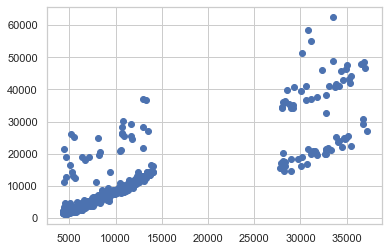

In [31]:
fig, ax = plt.subplots()
ax.plot(second_predictions, y_test['charges'], "o", label = "Data")

In [32]:
print(sm.tools.eval_measures.rmse(y_test['charges'], second_predictions))
print(np.sqrt(fitted_second_model.mse_resid))

6705.324001728618
6315.374004642929


This is a huge improvement from the previous model but still very poor.  

The RMSE is half of the previous model and we can see the present of a clear division in the data consistent with the introduction of a classification variable - in this case the smokers. 

In the next section the data shall log transformed to see if there any improvements.

## Log transforming the data
As the transformation is only applied to the Y value we can retain many of the existing variables.

In [33]:
logged_y_train = np.log10(y_train['charges'])
logged_y_test = np.log10(y_test['charges'])

In [34]:
### training and testing
intial_logged_model = sm.OLS(logged_y_train, X_train)
fitted_initial_logged_model = intial_logged_model.fit()

In [35]:
print(fitted_initial_logged_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     399.4
Date:                Sat, 16 Oct 2021   Prob (F-statistic):          3.35e-294
Time:                        13:17:17   Log-Likelihood:                 234.67
No. Observations:                 936   AIC:                            -451.3
Df Residuals:                     927   BIC:                            -407.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0150      0.000     33.027      0.0

In this case we can see only 'sex' is the only feature to not be statistically significant. We will first test with just the age feature, as before. But before that we will see how this model performs

In [36]:
logged_predictions = fitted_initial_logged_model.predict(X_test)

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


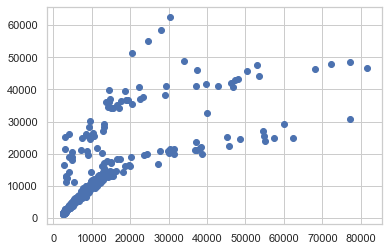

In [37]:
fig, ax = plt.subplots()
ax.plot(10**logged_predictions, 10**logged_y_test, "o", label = "Data")

In [38]:
print(sm.tools.eval_measures.rmse(10**logged_y_test, 10**logged_predictions))
print(np.sqrt(fitted_initial_logged_model.mse_resid))

9062.848601970942
0.18922323969207885


#### A model which uses only the age feature

In [39]:
### training and testing
age_only_logged_model = sm.OLS(logged_y_train, X_train['age'])
fitted_age_only_logged_model = age_only_logged_model.fit()

In [40]:
print(fitted_age_only_logged_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                              9984.
Date:                Sat, 16 Oct 2021   Prob (F-statistic):                        0.00
Time:                        13:17:17   Log-Likelihood:                         -1470.4
No. Observations:                 936   AIC:                                      2943.
Df Residuals:                     935   BIC:                                      2948.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [41]:
age_only_predictions = fitted_age_only_logged_model.predict(X_test['age'])

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


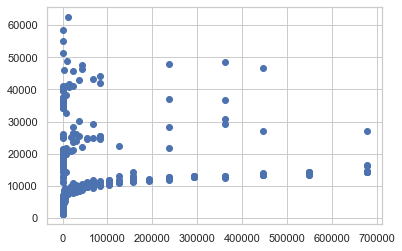

In [42]:
fig, ax = plt.subplots()
ax.plot(10**age_only_predictions, 10**logged_y_test, "o", label = "Data")

In [43]:
print(sm.tools.eval_measures.rmse(10**logged_y_test, 10**age_only_predictions))
print(np.sqrt(fitted_age_only_logged_model.mse_resid))

151944.81502223277
1.1648250528114772


The age only model leads to a model with a significantly RMSE. So whilst age is significant its not enough to build a model on. 

#### A model using age, bmi, smoker and geography features

In [44]:
### training and testing
multi_feature_logged_model = sm.OLS(logged_y_train, X_train[['age','bmi','smoker','southeast','southwest','northeast','northwest']])
fitted_multi_feature_logged_model = multi_feature_logged_model.fit()

In [45]:
print(fitted_multi_feature_logged_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     475.9
Date:                Sat, 16 Oct 2021   Prob (F-statistic):          2.90e-279
Time:                        13:17:18   Log-Likelihood:                 193.64
No. Observations:                 936   AIC:                            -373.3
Df Residuals:                     929   BIC:                            -339.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0152      0.000     32.154      0.0

In [46]:
mutli_feat_predictions = fitted_multi_feature_logged_model.predict(X_test[['age','bmi','smoker','southeast','southwest','northeast','northwest']])

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


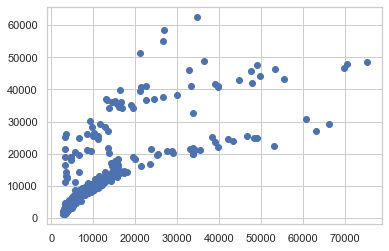

In [47]:
fig, ax = plt.subplots()
ax.plot(10**mutli_feat_predictions, 10**logged_y_test, "o", label = "Data")

In [48]:
print(sm.tools.eval_measures.rmse(10**logged_y_test, 10**mutli_feat_predictions))
print(np.sqrt(fitted_multi_feature_logged_model.mse_resid))

8398.282891127637
0.19749047208870588


The log transformation experiments show the model does not perform better, compared to the original dataset. A model using the log transformed dataset requires a greater number of features and still does not produce an RMSE as good as the vanilla models. 

One of the issues of using log transformation is that it can introduce bias into the data. The transformation removes the clear difference introduced in costs caused by being a smoker. 

In the next section I explore normalising the data. 

## Normalising the data
As the data used is on different scales as normaliser will be used. It will be fitted on the train set and applied to the test set. 

In [49]:
data_normalizer = Normalizer()
data_normalizer = data_normalizer.fit(X_train)
normalizer_train_set = data_normalizer.transform(X_train)
normalizer_train_set = pd.DataFrame(normalizer_train_set, columns=list(X_train.columns))
normalizer_train_set = normalizer_train_set.set_index(X_train.index)

In [50]:
normalizer_test_set = data_normalizer.transform(X_test)
normalizer_test_set = pd.DataFrame(normalizer_test_set, columns=X_test.columns)
normalizer_test_set = normalizer_test_set.set_index(X_test.index)

In [51]:
normalizer_train_set[['age','bmi','smoker']]

,age,bmi,smoker
1029,0.904609,0.422721,0.000000
1244,0.474855,0.879273,0.000000
952,0.725722,0.687137,0.000000
1023,0.609969,0.790249,0.000000
243,0.748338,0.660409,0.000000
...,...,...,...
1022,0.792774,0.608581,0.016868
1032,0.731689,0.681202,0.000000
165,0.854816,0.513162,0.000000
1151,0.846396,0.532354,0.000000


In [52]:
### training and testing
third_model = sm.OLS(y_train, normalizer_train_set[['age','bmi','smoker']])
fitted_third_model = third_model.fit()

In [53]:
print(fitted_third_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.791
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              1178.
Date:                Sat, 16 Oct 2021   Prob (F-statistic):                   1.23e-316
Time:                        13:17:18   Log-Likelihood:                         -9774.8
No. Observations:                 936   AIC:                                  1.956e+04
Df Residuals:                     933   BIC:                                  1.957e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The normalisation has made all of the features significant. However, the adjusted r-squared value has decreased to .79. 

In [54]:
third_predictions = fitted_third_model.predict(normalizer_test_set[['age','bmi','smoker']])

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0, 70000)

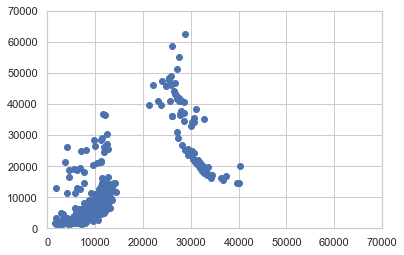

In [55]:
fig, ax = plt.subplots()
ax.plot(third_predictions, y_test['charges'], "o", label = "Data")
plt.xlim([0,70000])
plt.ylim([0,70000])

In [56]:
print(sm.tools.eval_measures.rmse(y_test['charges'], third_predictions))
print(np.sqrt(fitted_third_model.mse_resid))

8262.622352293378
8315.391368460248


The normalisation of the same features which produced the best model did not yield an improved model. The RMSE is roughly $1500 more than the best model. 

The next model will use all the normalised features. 

## All normalised features model

In [57]:
### training and testing
normalised_model = sm.OLS(y_train, normalizer_train_set)
fitted_normalised_model = normalised_model.fit()

In [58]:
print(fitted_normalised_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.846
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              565.4
Date:                Sat, 16 Oct 2021   Prob (F-statistic):                        0.00
Time:                        13:17:18   Log-Likelihood:                         -9632.4
No. Observations:                 936   AIC:                                  1.928e+04
Df Residuals:                     927   BIC:                                  1.933e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [59]:
normalised_predictions = fitted_normalised_model.predict(normalizer_test_set)

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0, 70000)

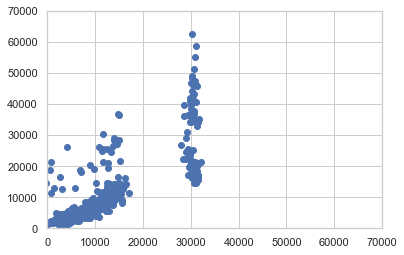

In [60]:
fig, ax = plt.subplots()
ax.plot(normalised_predictions, y_test['charges'], "o", label = "Data")
plt.xlim([0,70000])
plt.ylim([0,70000])

In [61]:
print(sm.tools.eval_measures.rmse(y_test['charges'], normalised_predictions))
print(np.sqrt(fitted_normalised_model.mse_resid))

7160.664217575261
7164.980957419713


### Excluding the non-significant features

In [62]:
### training and testing
normalised_model_v2 = sm.OLS(y_train, normalizer_train_set[['age','bmi','smoker','northeast','northwest','southeast','southwest']])
fitted_normalised_model_v2 = normalised_model_v2.fit()

In [75]:
print(fitted_normalised_model_v2.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.845
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              726.3
Date:                Sat, 16 Oct 2021   Prob (F-statistic):                        0.00
Time:                        13:28:29   Log-Likelihood:                         -9633.7
No. Observations:                 936   AIC:                                  1.928e+04
Df Residuals:                     929   BIC:                                  1.932e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [64]:
normalised_predictions_V2 = fitted_normalised_model_v2.predict(normalizer_test_set[['age','bmi','smoker','northeast','northwest','southeast','southwest']])

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0, 70000)

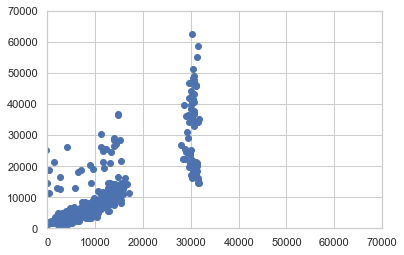

In [65]:
fig, ax = plt.subplots()
ax.plot(normalised_predictions_V2, y_test['charges'], "o", label = "Data")
plt.xlim([0,70000])
plt.ylim([0,70000])

In [66]:
print(sm.tools.eval_measures.rmse(y_test['charges'], normalised_predictions_V2))
print(np.sqrt(fitted_normalised_model_v2.mse_resid))

7163.022507798844
7166.567404296226


### Using other forms of regression: lasso, ridge, and polynomial
Ridge regression is a regularized version of LR. In this instance it adds a regularization term to the cost function. The aim of this is to force the model to keep the weights as small as possible when fitting the data. The regularization term is only added to the cost function during train. 

As the standard data seemed to perform best I will focus on using only that dataset. 

In [80]:
### training and testing
simple_ridge_model = sm.OLS(y_train, X_train)
fitted_simple_ridge_model = simple_ridge_model.fit_regularized(alpha=0.5)

In [83]:
print(fitted_simple_ridge_model.params)

age            264.902834
sex            151.415234
bmi            287.213897
children       470.890822
smoker       23974.020212
northeast   -10897.243601
northwest   -11298.309346
southeast   -11825.814519
southwest   -11912.458308
dtype: float64


In [84]:
ridge_predictions = fitted_simple_ridge_model.predict(X_test)

(0, 70000)

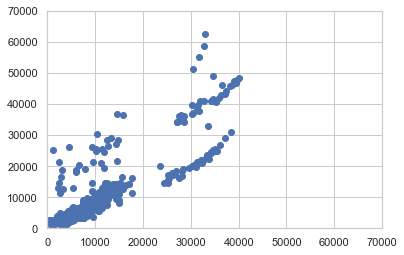

In [85]:
fig, ax = plt.subplots()
ax.plot(ridge_predictions, y_test['charges'], "o", label = "Data")
plt.xlim([0,70000])
plt.ylim([0,70000])

In [87]:
print(sm.tools.eval_measures.rmse(y_test['charges'], ridge_predictions))

6338.42124150841


#### Lasso regression
Lasso regression, aka Least Absolute Shrinkage and Selection and Operator Regression, is another linear regression method which uses regularization on the cost function. Instead of using the L2 norm, its uses the L1 norm of the weight vector instead of half teh square of the l2 norm. 

In [91]:
### training and testing
simple_lasso_model = sm.OLS(y_train, X_train)
fitted_simple_lasso_model = simple_lasso_model.fit_regularized(method = 'sqrt_lasso')

In [92]:
print(fitted_simple_lasso_model.params)

age            262.190209
sex            113.799890
bmi            316.022846
children       496.646006
smoker       24031.127817
northeast   -11664.626112
northwest   -12059.260204
southeast   -12706.045556
southwest   -12709.232083
dtype: float64


In [93]:
lasso_predictions = fitted_simple_lasso_model.predict(X_test)

(0, 70000)

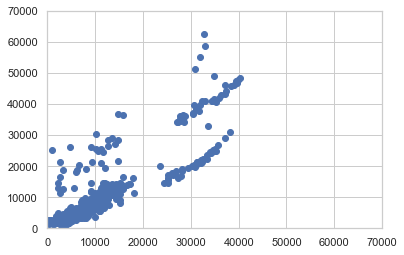

In [94]:
fig, ax = plt.subplots()
ax.plot(lasso_predictions, y_test['charges'], "o", label = "Data")
plt.xlim([0,70000])
plt.ylim([0,70000])

In [95]:
print(sm.tools.eval_measures.rmse(y_test['charges'], lasso_predictions))

6324.691438644852


#### Polynomial regression model
The charges belonging to smokers prevent a clear linear pattern from appearing, but instead ensure that the data has two demonstrably unique patterns. One way to potentially deal with this is to use polynomial regression. This involves generating a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree, in this case two.

In [131]:
## polynomial transformation - using np
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree = 2)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.fit_transform(X_test)

In [132]:
### training and testing
simple_poly_model = sm.OLS(y_train, X_train_poly)
fitted_simple_poly_model = simple_poly_model.fit()

In [133]:
print(fitted_simple_poly_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     156.0
Date:                Sat, 16 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:50:26   Log-Likelihood:                -9208.9
No. Observations:                 936   AIC:                         1.849e+04
Df Residuals:                     899   BIC:                         1.867e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.6342   2669.121     -0.010      0.9

In [134]:
poly_predictions = fitted_simple_poly_model.predict(X_test_poly)

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0, 70000)

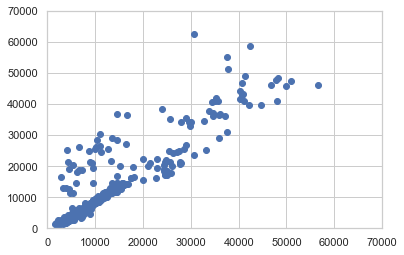

In [135]:
fig, ax = plt.subplots()
ax.plot(poly_predictions, y_test['charges'], "o", label = "Data")
plt.xlim([0,70000])
plt.ylim([0,70000])

In [136]:
print(sm.tools.eval_measures.rmse(y_test['charges'], poly_predictions))
print(np.sqrt(fitted_simple_poly_model.mse_resid))

5186.915699115621
4627.447319894088


The polynomial model has performed slightly better than the base model, but its created lots of redundant features. Using feature selection I explore whether it can be improved. 

In [195]:
from sklearn.feature_selection import SelectKBest, f_regression
# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_train_poly, y_train)

C:\Users\darre\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\darre\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\darre\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\darre\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [251]:
sig_features_to_test = []
for i in range(len(fs.scores_)):
     if fs.scores_[i] >= 10:
            sig_features_to_test.append(i)

In [252]:
### model building
### training and testing
poly_model2 = sm.OLS(np.array(y_train), np.array(pd.DataFrame(X_train_poly)[sig_features_to_test]))
fitted_poly_model2 = poly_model2.fit()

In [253]:
print(fitted_poly_model2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              746.8
Date:                Mon, 18 Oct 2021   Prob (F-statistic):                        0.00
Time:                        16:27:43   Log-Likelihood:                         -9220.7
No. Observations:                 936   AIC:                                  1.848e+04
Df Residuals:                     918   BIC:                                  1.856e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [254]:
poly_predictions2 = fitted_poly_model2.predict(np.array(pd.DataFrame(X_test_poly)[sig_features_to_test]))

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0, 70000)

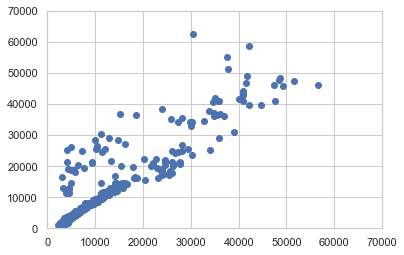

In [255]:
fig, ax = plt.subplots()
ax.plot(poly_predictions2, y_test['charges'], "o", label = "Data")
plt.xlim([0,70000])
plt.ylim([0,70000])

In [256]:
print(sm.tools.eval_measures.rmse(y_test['charges'], poly_predictions2))
print(np.sqrt(fitted_poly_model2.mse_resid))

5218.937395069773
4637.356161852974


The reduced features polynomial model is slightly worse than the polynomial model with all features. However, it contains less than half the number of features and only comprimises on RMSE marginally. Depending on the preference for a less complex model compared to a model with a better RMSE we are left with two good models to predict the charges for health insurance. 